**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

In [4]:
# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=2, cluster_std=[1.7,1.8] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(10000, 3) (10000,)


In [6]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

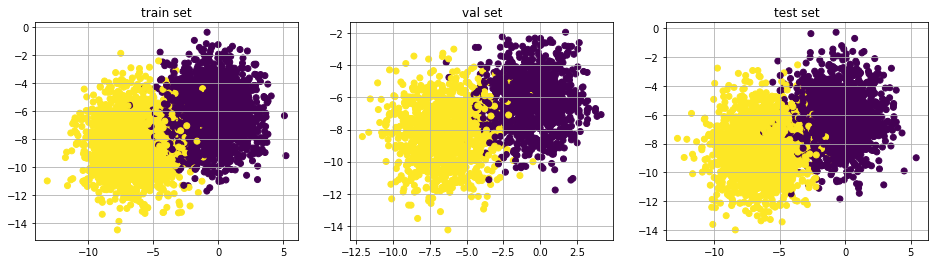

In [7]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [8]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## LogisticRegression + CCE + GD

  8%|▊         | 2/25 [00:00<00:00, 606.42it/s, loss=0.208, lr=0.009]

(4489, 1) (2211, 1) (3300, 1)
[[0]
 [1]
 [0]]
(3, 1)
[INFO    ] 2021-10-04 23:17:32 | GrowthBreaking: significant increase in the loss function has been detected


score threshold:0.6033307202682201

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1640
           1       0.95      0.94      0.94      1660

    accuracy                           0.94      3300
   macro avg       0.94      0.94      0.94      3300
weighted avg       0.94      0.94      0.94      3300



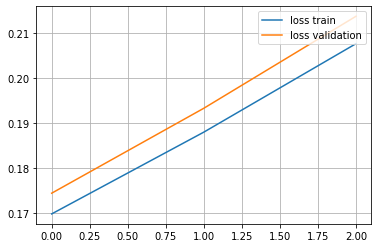

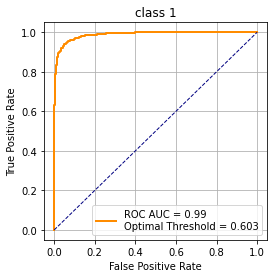

In [32]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis] for t in [ target_train, target_val, target_test ] ]
# выход = метка класса

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import SLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP( # логистическая регрессия 1./(1.+np.exp(-x.dot(w)) )
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.cce import CCE # ф-ция потери - кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.009),
    breaker_val=[GrowthBreaking(),]

).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## LinearClassifier + Hinge + GD

  8%|▊         | 2/25 [00:00<00:00, 351.37it/s, loss=0.679, lr=0.0095]

(4489, 1) (2211, 1) (3300, 1)
[[-1]
 [ 1]
 [-1]]
(3, 1)
[INFO    ] 2021-10-04 23:17:51 | GrowthBreaking: significant increase in the loss function has been detected


score threshold:0.5668565949851332

              precision    recall  f1-score   support

          -1       0.95      0.96      0.95      1640
           1       0.96      0.95      0.95      1660

    accuracy                           0.95      3300
   macro avg       0.95      0.95      0.95      3300
weighted avg       0.95      0.95      0.95      3300



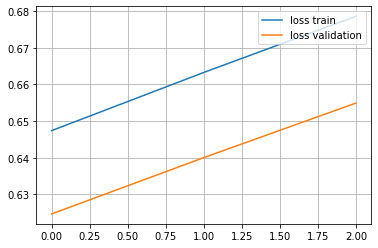

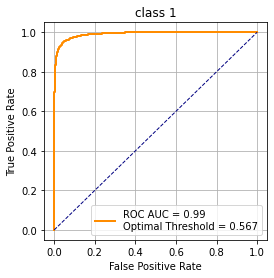

In [34]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход = метка класса {-1,1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import LinearClassifier
from lib.initiator.linear import NormalInitiatorLinearModel

model = LinearClassifier(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.hinge import HingeLoss
loss_train = HingeLoss(model)
loss_val = HingeLoss(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.0095),
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## SPL_BPS + Hinge + SGD

  8%|▊         | 2/25 [00:00<00:00, 327.64it/s, loss=0.7, lr=1e-5]

(4489, 1) (2211, 1) (3300, 1)
[[-1]
 [ 1]
 [-1]]
(3, 1)
[INFO    ] 2021-10-04 23:19:16 | GrowthBreaking: significant increase in the loss function has been detected


score threshold:0.5838784026429455

              precision    recall  f1-score   support

          -1       0.95      0.97      0.96      1640
           1       0.97      0.95      0.96      1660

    accuracy                           0.96      3300
   macro avg       0.96      0.96      0.96      3300
weighted avg       0.96      0.96      0.96      3300



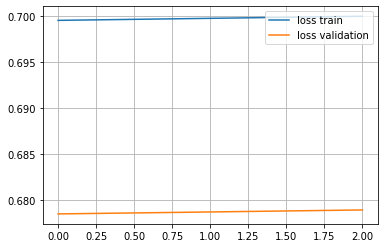

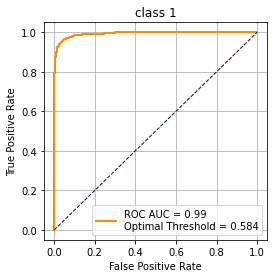

In [44]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход = метка класса {-1,1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import SLP_BPS
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP_BPS(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.hinge import HingeLoss
loss_train = HingeLoss(model)
loss_val = HingeLoss(model)

from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = SGD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.00001),
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
    batch_size=len(y_train)//10,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## SPL_BPS + Logistic + GD

100%|██████████| 25/25 [00:00<00:00, 492.56it/s, loss=1.23, lr=0.0001]

(4489, 1) (2211, 1) (3300, 1)
[[-1]
 [ 1]
 [-1]]
(3, 1)


score threshold:0.8236700078389726

              precision    recall  f1-score   support

          -1       0.83      0.83      0.83      1640
           1       0.83      0.83      0.83      1660

    accuracy                           0.83      3300
   macro avg       0.83      0.83      0.83      3300
weighted avg       0.83      0.83      0.83      3300



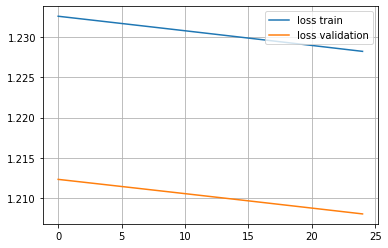

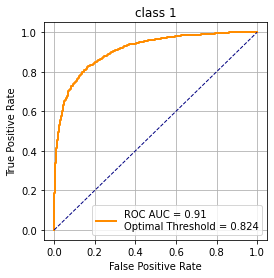

In [46]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход = метка класса {-1,1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import SLP_BPS
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP_BPS(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.logistic import LogisticLoss
loss_train = LogisticLoss(model)
loss_val = LogisticLoss(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.0001),
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## SPL_BPS + Logistic + Adam

 28%|██▊       | 44/155 [00:00<00:00, 437.75it/s, loss=0.439, lr=0.0001]

(4489, 1) (2211, 1) (3300, 1)
[[-1]
 [ 1]
 [-1]]
(3, 1)


100%|██████████| 155/155 [00:00<00:00, 432.78it/s, loss=0.437, lr=0.0001]


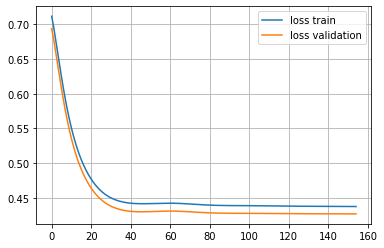

In [67]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход = метка класса {-1,1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import SLP_BPS
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP_BPS(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.logistic import LogisticLoss
loss_train = LogisticLoss(model)
loss_val = LogisticLoss(model)

from lib.optimizer.gd import Adam # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = Adam(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.0001),
    breaker_val=[GrowthBreaking(delta=1e-3),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=155,
    batch_size=len(y_train)//10
)

from lib.estimator.loss import LossPlot
LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()


#from lib.estimator.classifier import BinnaryClassifierScoreThreshold
#model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

score threshold:-0.97373804700587

              precision    recall  f1-score   support

          -1       0.73      0.76      0.75      1640
           1       0.76      0.72      0.74      1660

    accuracy                           0.74      3300
   macro avg       0.74      0.74      0.74      3300
weighted avg       0.74      0.74      0.74      3300



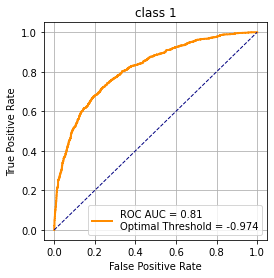

In [68]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

---

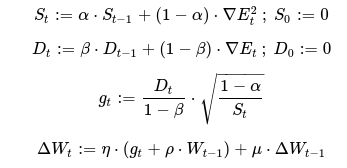

In [29]:
# from lib.optimizer.gd import SGD 
# from lib.optimizer.lrate import ConstLRA
# from lib.optimizer.regularizator import Regularization
# # from lib.optimizer.breaker import FitBreakException
# from lib.loss.base import EmptyLoss


# class Adam(SGD):
    
#     def __init__(
#         self,
#         loss,
#         loss_val=EmptyLoss(),
#         lra=ConstLRA(.1),
#         breaker=[],
#         breaker_val=[],
#         regul=Regularization(1.),
#         momentum=0.,
#         a=.999,
#         b=.99,
#     ):
#         super().__init__(
#             loss=loss,
#             loss_val=loss_val,
#             lra=lra,
#             breaker=breaker,
#             breaker_val=breaker_val,
#             regul=regul,
#             momentum=momentum,
#         )
#         self._S = .0
#         self._D = .0
#         self._a = a
#         self._b = b
        
        
#     def _weight_delta(self,data,lr):
#         x,t = data
#         d_loss = self._loss.gradient(x,t) # значение градиента ф-ции потери
#         self._S = self._a*self._S+(1.-self._a)* np.square(d_loss)
#         self._D = self._b*self._D+(1-self._b)*d_loss
#         g = (self._D/(1.-self._b))*np.sqrt((1.-self._a)/self._S)
#         return (
#             lr*( 
#                 g # значение градиента ф-ции потери
#                 + self._regularizator.transform(self._loss.model.weight) # добавка регуляризатора
#                 ) 
#                 + self._momentum * self._dweight # добавка момента
#             )
